In [6]:
cd
build_path niak psom
cd /home/pbellec/git/niak_tutorials/connectome

Adding library niak to the search path.

Adding library psom to the search path.



# Connectome pipeline
This tutorial shows how to use the NIAK connectome pipeline to generate seed-based functional connectivity maps on a single subject from the COBRE "lightweight" sample. See the [documentation](http://niak.simexp-lab.org/pipe_connectome.html) of the pipeline for a more detailed description of the options. Download the tutorial as a notebook [here](https://raw.githubusercontent.com/SIMEXP/niak_tutorials/master/connectome/niak_tutorial_rmap_connectome.ipynb) and a matlab script [here](https://raw.githubusercontent.com/SIMEXP/niak_tutorials/master/connectome/niak_tutorial_rmap_connectome.m). To run this tutorial, we recommend to use [jupyter](http://jupyter.org/) from a niak docker container, as described in the [NIAK installation page](http://niak.simexp-lab.org/niak_installation.html). 

## Preparing files

### Functional MRI 
First download a small preprocessed fMRI dataset. 

In [7]:
clear
path_data = [pwd filesep];
[status,msg,data_fmri] = niak_wget('cobre_lightweight20_nii');

When starting from fMRI data preprocessed with NIAK, it is possible to use `niak_grab_fmri_preprocess` on the output folder to collect the file names, as described in the [pipeline documentation](http://niak.simexp-lab.org/pipe_connectome.html). In this case, we explicitely list all the files

In [4]:
file_pheno = [data_fmri.path filesep 'phenotypic_data.tsv.gz'];
tab = niak_read_csv_cell(file_pheno);
list_subject = tab(2:end,1);
files_in = struct;
for ss = 1:length(list_subject)
    files_in.fmri.(list_subject{ss}).sess1.rest = [data_fmri.path filesep 'fmri_' list_subject{ss} '.nii.gz'];
end

### Brain parcellation
The second input of the pipeline is a set of brain parcels. We will just download the so-called Cambridge functional template. 



In [5]:
[status,msg,data_template] = niak_wget('cambridge_template_mnc1');

We are going to pick the parcellation into 7 distributed networks.

In [6]:
files_in.network = [data_template.path filesep 'template_cambridge_basc_multiscale_sym_scale007.mnc.gz'];

### List of seeds

The next step is to generate a list of seeds. This requires creating a text file that looks like:
```
        , index
 MOTOR  , 3
 DMN    , 5
```
We are going to use NIAK's tool to write comma-separated values (CSV) in a file:

In [7]:
files_in.seeds = [path_data 'list_seeds.csv'];
opt_csv.labels_x = { 'MOTOR' , 'DMN' }; % The labels for the network
opt_csv.labels_y = { 'index' };
tab = [3 ; 5];
niak_write_csv(files_in.seeds,tab,opt_csv);

# Set the options of the pipeline
Now we set up where to store the results:

In [8]:
opt.folder_out = [path_data 'connectome'];

We set options such that we will not generate graph properties, just the correlation maps:

In [9]:
opt.flag_p2p = false; % No parcel-to-parcel correlation values
opt.flag_global_prop = false; % No global graph properties
opt.flag_local_prop  = false; % No local graph properties
opt.flag_rmap = true; % Generate correlation maps

# Run the pipeline
Now let's run the pipeline:

In [10]:
opt.flag_test = false; 
[pipeline,opt] = niak_pipeline_connectome(files_in,opt); 

Adding seed MOTOR (parcel number 3)
Adding seed DMN (parcel number 5)

Logs will be stored in /home/pbellec/git/niak_tutorials/connectome/connectome/logs/
Generating dependencies ...
   Percentage completed :  0 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100- 0.05 sec
Setting up the to-do list ...
   I found 43 job(s) to do.
Deamon started on 25-Nov-2016 22:55:31
25-Nov-2016 22:55:31 Starting the pipeline manager...
25-Nov-2016 22:55:31 Starting the garbage collector...
25-Nov-2016 22:55:31 Starting worker number 1...

Pipeline started on 25-Nov-2016 22:55:32
user: pbellec, host: acacia, system: unix
*****************************************
25-Nov-2016 22:55:33 mask_rois          submitted  (1 run / 0 fail / 0 done / 42 left)
25-Nov-2016 22:55:35 mask_rois          finished   (0 run / 0 fail / 1 done / 42 left)
25-Nov-2016 22:55:35 connectome_40061   submitted  (1 run / 0 fail / 1 done / 41 left)
25-Nov-2016 22:55:35 connectome_40117   submitted  (2 run / 0 fail / 1 done 

# Reviewing outputs

All the correlation maps have been generated in the subfolder called `rmap_seeds`, inside the output folder. There are first two average (across all subjects) maps, for each selected seed. We can have a quick look at them. Note that the files have been named using the identification codes in the file `files_in.seeds`.  

In [11]:
file_dmn   = [opt.folder_out filesep 'rmap_seeds' filesep 'average_rmap_DMN.nii.gz'];
file_motor = [opt.folder_out filesep 'rmap_seeds' filesep 'average_rmap_MOTOR.nii.gz'];
[hdr,rmap_dmn]   = niak_read_vol(file_dmn);
[hdr,rmap_motor] = niak_read_vol(file_motor);
size(rmap_dmn)
size(rmap_motor)

ans =

   27   32   26

ans =

   27   32   26



We will now use `niak_vol2img` to generate a series of axial slices for both maps. 

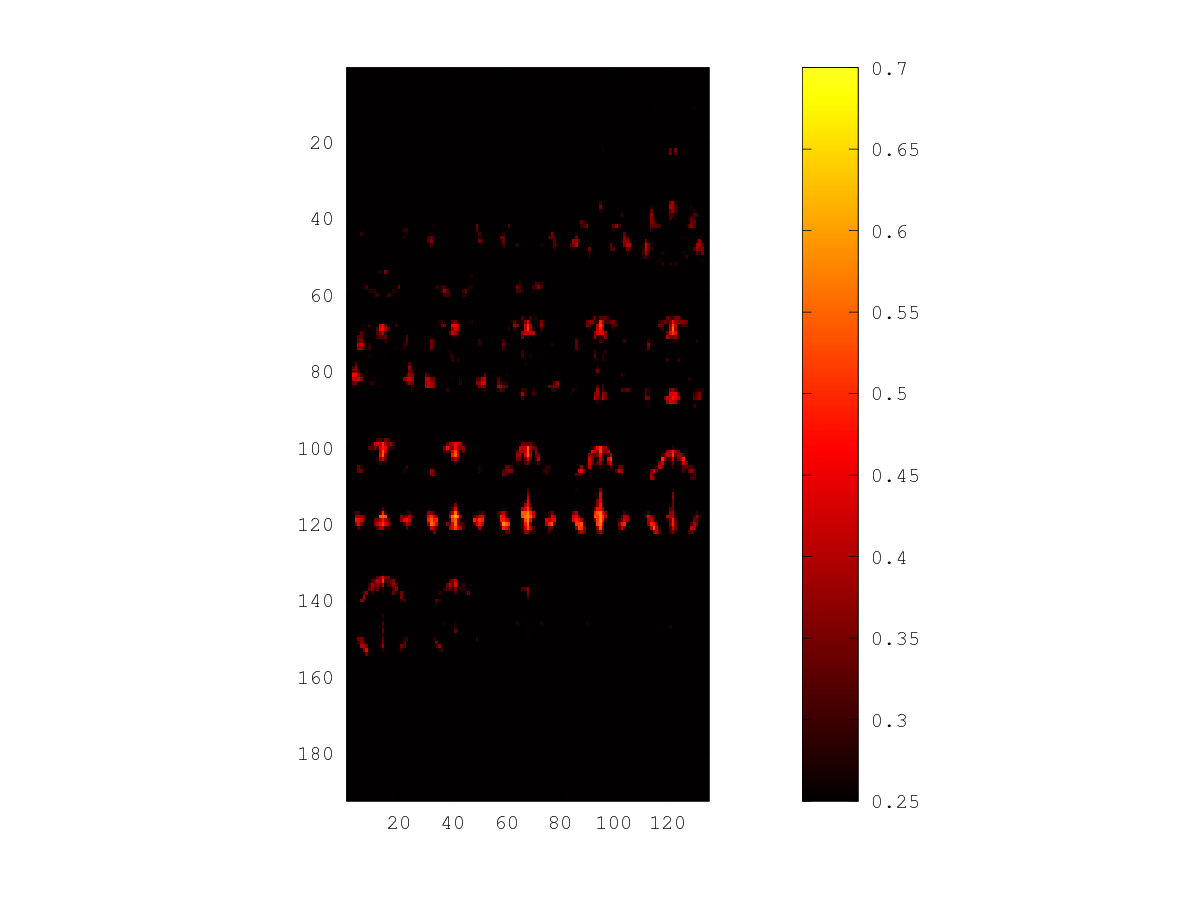

In [12]:
% The default-mode network
opt_v = struct;
opt_v.vol_limits = [0.25 0.7];
opt_v.type_color = 'hot_cold';
niak_montage(rmap_dmn,opt_v)

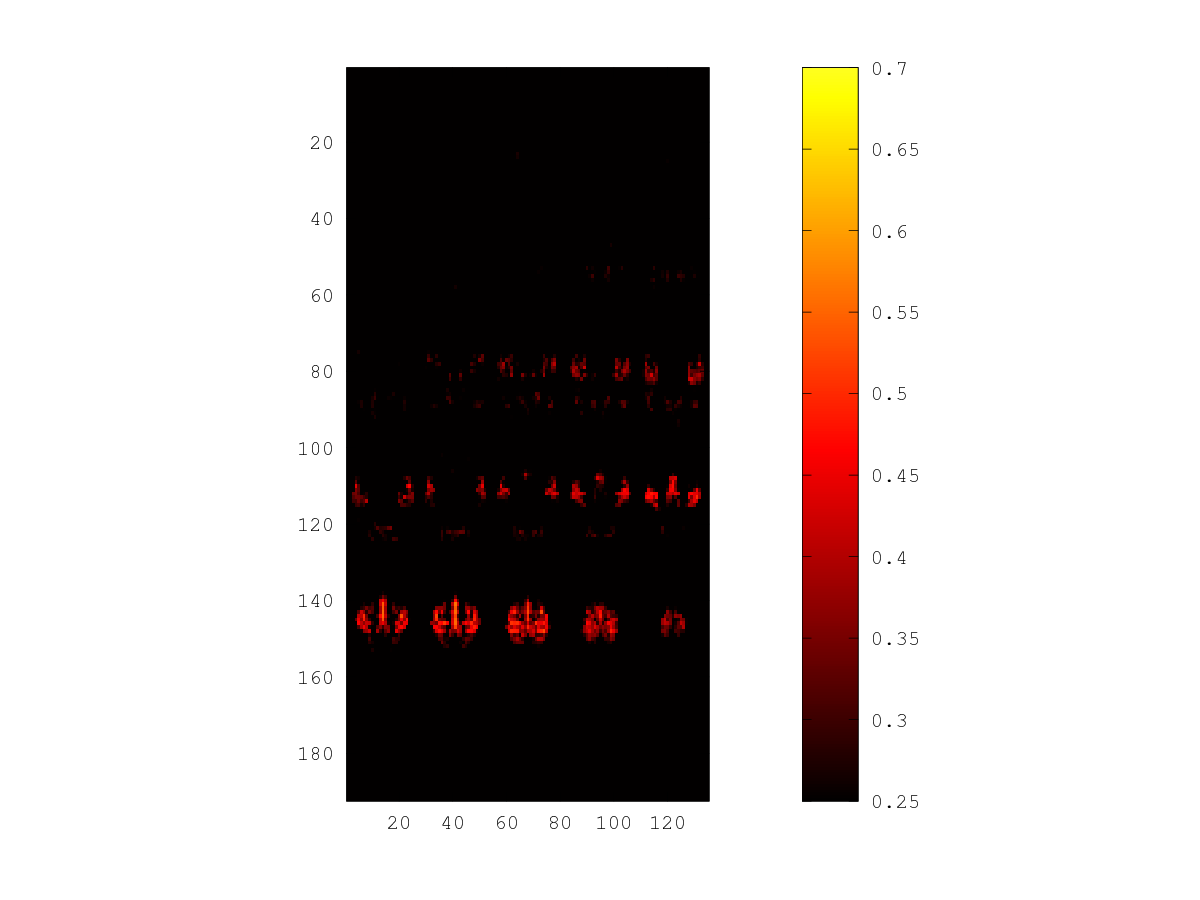

In [13]:
% The sensorimotor network
opt_v = struct;
opt_v.vol_limits = [0.25 0.7];
opt_v.type_color = 'hot_cold';
niak_montage(rmap_motor,opt_v)

There are also two files which contain the seeds as binary masks. E.g.:

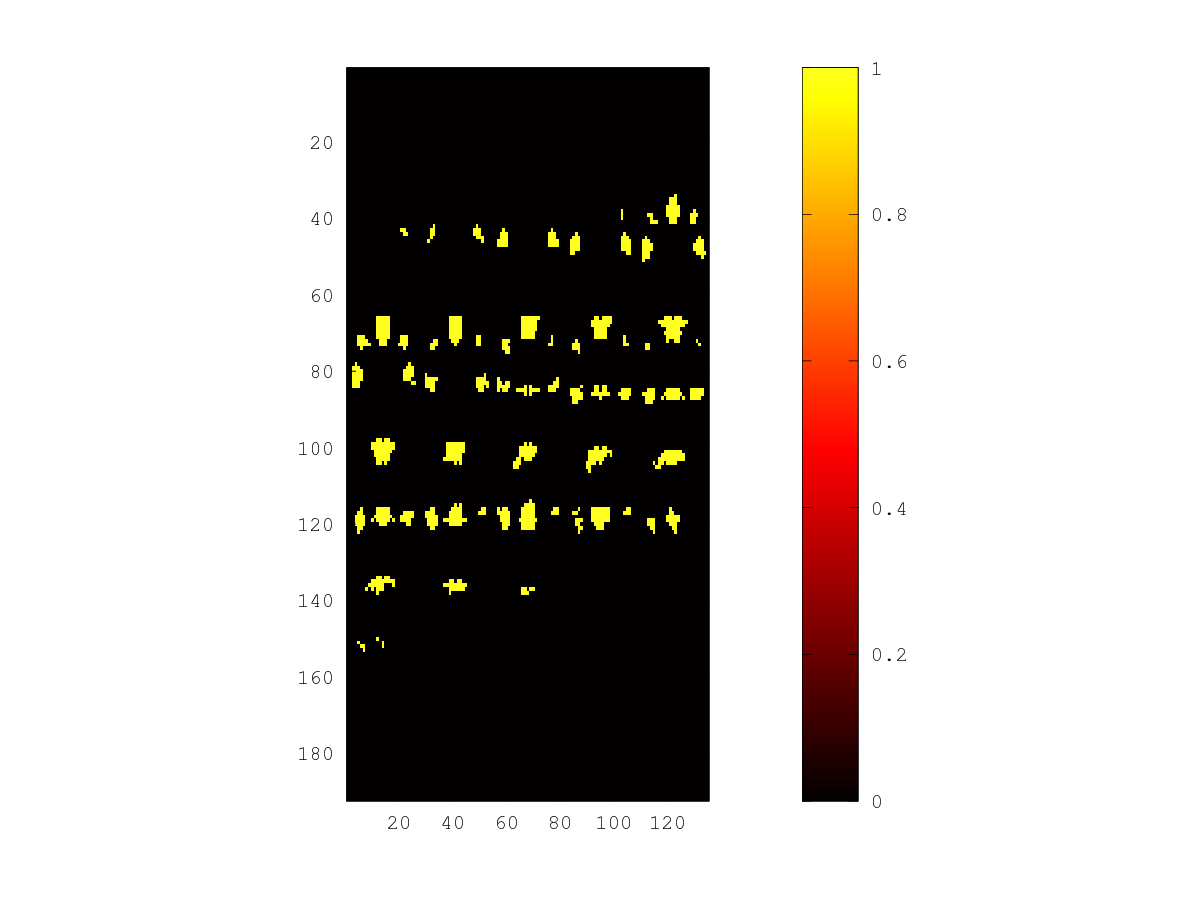

In [14]:
file_mask_dmn   = [opt.folder_out filesep 'rmap_seeds' filesep 'mask_DMN.nii.gz'];
[hdr,mask_dmn]   = niak_read_vol(file_mask_dmn);
opt_v = struct;
opt_v.vol_limits = [0 1];
opt_v.type_color = 'hot_cold';
niak_montage(mask_dmn,opt_v)

Finally, there are also individual connectivity maps for each subject, named using the IDs we used in `files_in.fmri`. If multiple runs were specified per subject, the pipeline would average the maps from all runs.  

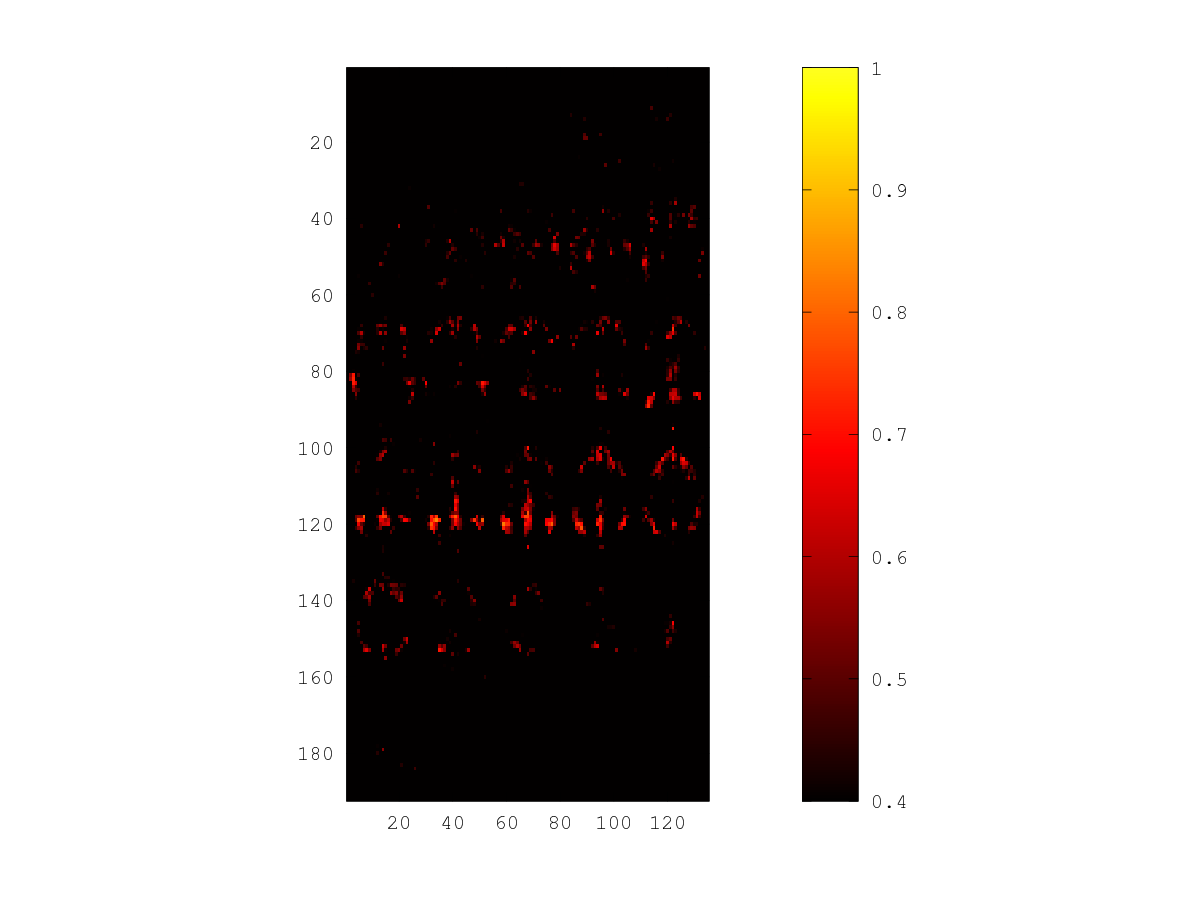

In [15]:
file_dmn_40003   = [opt.folder_out filesep 'rmap_seeds' filesep 'rmap_40003_DMN.nii.gz'];
[hdr,rmap_dmn_40003]   = niak_read_vol(file_dmn_40003);
opt_v = struct;
opt_v.vol_limits = [0.4 1];
opt_v.type_color = 'hot_cold';
niak_montage(rmap_dmn_40003,opt_v)